# Using Data Recorders

As ZnRND is at its core a package for scientific development, it comes with a powerfull data recording module which is demonstrated here.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import znrnd as rnd
import numpy as np

import matplotlib.pyplot as plt

from neural_tangents import stax
import optax

## Create a Data Generator

The first thing we need to do is create a data generator for the problem.

In [4]:
data_generator = rnd.data.MNISTGenerator()

## Define the Network

In [5]:
network = stax.serial(
    stax.Flatten(),
    stax.Dense(128),
    stax.Relu(),
    stax.Dense(10)
)

## Define the Data Recorders

In this case I want to track test and train data but at different intervals.

In [6]:
train_recorder = rnd.model_recording.JaxRecorder(
    loss=True,
    accuracy=True,
    update_rate=1
)
test_recorder = rnd.model_recording.JaxRecorder(
    loss=True,
    accuracy=True,
    update_rate=10
)

## Create Model and Prepare Recording

Before we train, we need to create a model and prepare the recorders. In this time, we add data and a model to the recorders. Note, any data can be added to the recorders here, even validation data.

In [7]:
production_model = rnd.models.NTModel(
            nt_module=network,
            optimizer=optax.adam(learning_rate=0.01),
            input_shape=(1, 28, 28, 1),
        )

In [8]:
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

## Create a training strategy

In order to train a model, we have to define a strategy how to train. 
The recorders and the model are an input to the strategy, as they record how the model trains.  

In [10]:
training_strategy = rnd.training_strategies.SimpleTraining(
    model=production_model, 
    loss_fn=rnd.loss_functions.CrossEntropyLoss(),
    accuracy_fn=rnd.accuracy_functions.LabelAccuracy(),
    recorders=[train_recorder, test_recorder]
)

## Train the model

In [12]:
batch_wise_loss = training_strategy.train_model(
    train_ds=data_generator.train_ds,
    test_ds=data_generator.test_ds,
    batch_size=32,
    recorders=[train_recorder, test_recorder],
    epochs=100
)

Epoch: 100: 100%|██████████████████████████████| 100/100 [00:21<00:00,  4.58batch/s, accuracy=0.884]


## Checking the Results

Now let's use the export function of the reporter to get access to an easy to plot dataclass with all of the metrics we recorded.

In [13]:
train_report = train_recorder.export_dataset()
test_report = test_recorder.export_dataset()

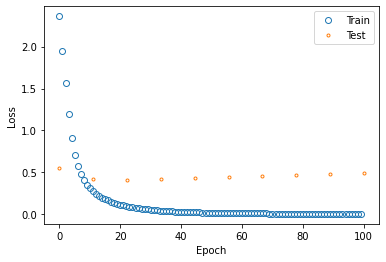

In [14]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(np.linspace(0, 100, 10), test_report.loss, '.', mfc="None", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

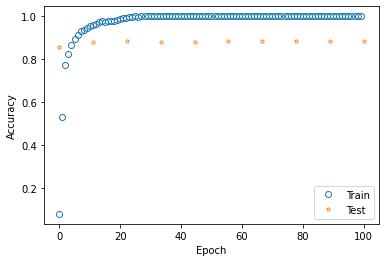

In [15]:
plt.plot(train_report.accuracy, 'o', mfc='None', label="Train")
plt.plot(np.linspace(0, 100, 10), test_report.accuracy, '.', mfc="None", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()